In [ ]:
# importing libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
from scipy.stats import entropy
#import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from scipy.stats import pearsonr

#warnings.filterwarnings('ignore')
mypath1 = '/content/drive/MyDrive/WISDM_ar_v1.1_raw.txt'
mypath = '/content/drive/MyDrive/time_series_data_human_activities.csv'



In [ ]:
# Open the file for reading
with open('/content/drive/MyDrive/WISDM_ar_v1.1_raw.txt', 'r') as file:
    lines = file.readlines()

processed_list = []

for i, line in enumerate(lines):
    try:
        # Split the line by comma
        parts = line.strip().split(',')

        # Check if there are at least 6 parts
        if len(parts) >= 6:
            # Split the last part by semicolon and take the first part
            last_part = parts[5].split(';')[0].strip()

            # Check if the last part is not empty
            if last_part:
                # Create a new list with the desired elements
                temp = [parts[0], parts[1], parts[2], parts[3], parts[4], last_part]
                processed_list.append(temp)
        else:
            print('Error at line number:', i, '- Not enough elements')
    except Exception as e:
        print('Error at line number:', i, '-', str(e))




Error at line number: 281873 - Not enough elements
Error at line number: 281874 - Not enough elements
Error at line number: 281875 - Not enough elements
Error at line number: 537501 - Not enough elements
Error at line number: 832901 - Not enough elements
Error at line number: 1098209 - Not enough elements


In [ ]:
#har_df = pd.read_csv(mypath)

har_df = pd.DataFrame(processed_list)
# Add the desired column names to the DataFrame
har_df.columns = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
# Convert 'x-axis,' 'y-axis,' and 'z-axis' columns to float
har_df[['x-axis', 'y-axis', 'z-axis']] = har_df[['x-axis', 'y-axis', 'z-axis']].astype(float)

# removing null values
har_df = har_df.dropna()
har_df.shape

# drop the rows where timestamp is 0
har_df = har_df[har_df['timestamp'] != 0]
# Drop rows where 'timestamp' is 0 and 'x-axis' is 0
har_df = har_df[har_df['x-axis'] != 0]
har_df = har_df[har_df['y-axis'] != 0]
har_df = har_df[har_df['z-axis'] != 0]



# now arrange data in ascending order of the user and timestamp
har_df = har_df.sort_values(by = ['user', 'timestamp'], ignore_index=True)

In [ ]:

# Assuming you have a DataFrame named har_df with the given columns
# Define the mapping for label consolidation
label_mapping = {
    'Upstairs': 'Stairs',
    'Downstairs': 'Stairs'
}

# Apply the label consolidation
har_df['activity'] = har_df['activity'].map(label_mapping).fillna(har_df['activity'])

# Print the first few rows of the modified DataFrame
#har_df['activity']
df = har_df


In [ ]:
# Calculate magnitude of acceleration and add it as a new column
df['magnitude'] = np.sqrt(df['x-axis']**2 + df['y-axis']**2 + df['z-axis']**2)

In [ ]:
df

,user,activity,timestamp,x-axis,y-axis,z-axis,magnitude
0,1,Walking,4991922345000,0.69,10.80,-2.03,11.010767
1,1,Walking,4991972333000,6.85,7.44,-0.50,10.125517
2,1,Walking,4992022351000,0.93,5.63,-0.50,5.728159
3,1,Walking,4992072339000,-2.11,5.01,-0.69,5.479808
4,1,Walking,4992122358000,-4.59,4.29,-1.95,6.578351
...,...,...,...,...,...,...,...
1075781,9,Walking,9614392347000,12.37,7.70,3.49,14.982890
1075782,9,Walking,9614442335000,10.84,6.78,1.14,12.836417
1075783,9,Walking,9614492292000,8.01,5.05,-0.04,9.469118
1075784,9,Walking,9614542341000,5.86,4.21,-1.18,7.311368


In [ ]:
x_list = []
y_list = []
z_list = []
m_list = []
labels = []

window_size = 100
step_size = 50

for i in range(0, df.shape[0] - window_size, step_size):
    xs = df['x-axis'].values[i: i + 100]
    ys = df['y-axis'].values[i: i + 100]
    zs = df['z-axis'].values[i: i + 100]
    ms = df['magnitude'].values[i: i + 100]
    unique_values, counts = np.unique(df['activity'].values[i: i + 100], return_counts=True)
    label = unique_values[np.argmax(counts)]


    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    m_list.append(ms)
    labels.append(label)




In [ ]:
import numpy as np

# Check for NaN values in x_list
nan_values_x = np.isnan(x_list)

# Check for NaN values in y_list
nan_values_y = np.isnan(y_list)

# Check for NaN values in z_list
nan_values_z = np.isnan(z_list)

# Check for NaN values in m_list
nan_values_m = np.isnan(m_list)

# Count the number of NaN values in each list
count_nan_x = np.sum(nan_values_x)
count_nan_y = np.sum(nan_values_y)
count_nan_z = np.sum(nan_values_z)
count_nan_m = np.sum(nan_values_m)

print("Number of NaN values in x_list:", count_nan_x)
print("Number of NaN values in y_list:", count_nan_y)
print("Number of NaN values in z_list:", count_nan_z)
print("Number of NaN values in m_list:", count_nan_m)


Number of NaN values in x_list: 0
Number of NaN values in y_list: 0
Number of NaN values in z_list: 0
Number of NaN values in m_list: 0


In [ ]:

# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[0:5])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[0:5])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[0:5])
m_list_fft = pd.Series(m_list).apply(lambda x: np.abs(np.fft.fft(x))[0:5])



In [ ]:
X_Data = pd.DataFrame()

# Calculate the total sum for 'y_list'
y_list_total_sum_abs = pd.Series(y_list).apply(lambda y: np.sum(np.abs(y)))

X_Data['y_total_sum_abs'] = y_list_total_sum_abs

# energy
X_Data['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(np.abs(x)**2))
X_Data['y_energy'] = pd.Series(x_list).apply(lambda x: np.sum(np.abs(x)**2))
X_Data['z_energy'] = pd.Series(y_list).apply(lambda x: np.sum(np.abs(x)**2))


In [ ]:

# Define a function to calculate the autocorrelation for a given segment
def calculate_autocorrelation(segment):
     #autocorrelation = np.correlate(segment, segment, mode='full')
     #correlation_coefficients = autocorrelation / np.max(autocorrelation)
     #return correlation_coefficients

    mu = segment.mean()

    autocorrelation = []

    for lag in range(0, 9):
        segment_series = pd.Series(segment)
        numerator = sum((segment_series - mu).iloc[lag:] * (segment_series.shift(lag) - mu).iloc[lag:])
        denominator = sum((segment_series - mu) ** 2)
        acf = numerator / denominator
        autocorrelation.append(acf)

    return np.array(autocorrelation)



# Assuming x_list, y_list, z_list, and m_list are your input data lists

# Calculate autocorrelation for 'z_list'
az_list = pd.Series(z_list).apply(lambda z: calculate_autocorrelation(z))

# Calculate autocorrelation for 'm_list'
am_list = pd.Series(m_list).apply(lambda m: calculate_autocorrelation(m))




In [ ]:
am_list[0]

array([ 1.        ,  0.37108723,  0.03309716, -0.35678418, -0.42643229,
       -0.26492064, -0.22339004, -0.14366564,  0.04013725])

In [ ]:

# Define a function to calculate skewness with limited precision
def safe_skew(x):
    return stats.skew(x, axis=0, bias=False)


# Define a function to calculate kurtosis with limited precision
def safe_kurtosis(x):
    return stats.kurtosis(x, axis=0, fisher=False, bias=False)


def calculate_rms(series):
    return np.sqrt(np.mean(series ** 2))

# mean
stats_columns = {
    'y_mean':pd.Series(y_list).apply(lambda x: x.mean()),
    'am_mean':pd.Series(am_list).apply(lambda x: x.mean()),

    #variance
    'y_variance':pd.Series(y_list).apply(lambda x: x.var()),
    'm_variance':pd.Series(m_list).apply(lambda x: x.var()),
    'am_variance':pd.Series(m_list).apply(lambda x: x.var()),

    # std dev
    'x_std':pd.Series(x_list).apply(lambda x: x.std()),
    'y_std':pd.Series(y_list).apply(lambda x: x.std()),
    'z_std':pd.Series(z_list).apply(lambda x: x.std()),
    'm_std':pd.Series(m_list).apply(lambda x: x.std()),

    # avg absolute diff
    'y_aad':pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x)))),
    'z_aad':pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x)))),
    'm_aad':pd.Series(m_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x)))),
    # median

    'y_median':pd.Series(y_list).apply(lambda x: np.median(x)),

    # median abs dev
    'x_mad':pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x)))),
    'm_mad':pd.Series(m_list).apply(lambda x: np.median(np.absolute(x - np.median(x)))),

    # interquartile range
    'm_IQR':pd.Series(m_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25)),

    # skewness
    'az_skewness':pd.Series(az_list).apply(lambda x: stats.skew(x)),

    # kurtosis
    'az_kurtosis':pd.Series(az_list).apply(lambda x: stats.kurtosis(x)),
    'x_rms':pd.Series(x_list).apply(lambda x: calculate_rms(x)),
    'y_rms':pd.Series(y_list).apply(lambda x: calculate_rms(x)),

}




stats_fft_columns = {
    'x_mean_fft':pd.Series(x_list_fft).apply(lambda x: x.mean()),
    'm_mean_fft':pd.Series(m_list_fft).apply(lambda x: x.mean()),

     # FFT std dev
    'z_std_fft':pd.Series(z_list_fft).apply(lambda x: x.std()),
      # FFT avg absolute diff
    'x_aad_fft':pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x)))),
     # avg absolute diff
    'x_mad_fft':pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x)))),
         # FFT energy
    'x_energy_fft' : pd.Series(x_list_fft).apply(lambda x: np.sum(np.abs(x)**2)),
    'y_energy_fft' : pd.Series(y_list_fft).apply(lambda x: np.sum(np.abs(x)**2)),
    'z_energy_fft' : pd.Series(z_list_fft).apply(lambda x: np.sum(np.abs(x)**2)),
    'x_rms_fft':pd.Series(x_list_fft).apply(lambda x: calculate_rms(x)),
    'y_rms_fft':pd.Series(y_list_fft).apply(lambda x: calculate_rms(x)),
    'z_rms_fft':pd.Series(z_list_fft).apply(lambda x: calculate_rms(x)),

}



X_Data = pd.concat([X_Data, pd.DataFrame(stats_columns), pd.DataFrame(stats_fft_columns)], axis=1)

# FFT min
x_min_fft = pd.Series(x_list_fft).apply(lambda x: x.min())
m_min_fft = pd.Series(m_list_fft).apply(lambda x: x.min())

# FFT max
x_max_fft = pd.Series(x_list_fft).apply(lambda x: x.max())
X_Data['x_max_fft'] = x_max_fft
X_Data['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_Data['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())
m_max_fft = pd.Series(m_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_Data['x_maxmin_diff_fft'] = x_max_fft - x_min_fft
X_Data['m_maxmin_diff_fft'] = m_max_fft - m_min_fft



In [ ]:
X_Data

,y_total_sum_abs,x_energy,y_energy,z_energy,y_mean,am_mean,y_variance,m_variance,am_variance,x_std,...,y_energy_fft,z_energy_fft,x_rms_fft,y_rms_fft,z_rms_fft,x_max_fft,y_max_fft,z_max_fft,x_maxmin_diff_fft,m_maxmin_diff_fft
0,983.53,4668.0633,4668.0633,11203.9885,9.8353,0.003237,15.306759,23.730810,23.730810,5.611051,...,9.686300e+05,2332.598225,174.792024,440.143160,21.599066,389.83,983.53,40.56,385.736495,1197.677963
1,989.88,4855.3609,4855.3609,11722.0326,9.8988,0.008800,19.234085,27.144976,27.144976,5.806854,...,9.802345e+05,4165.654645,172.577645,442.771837,28.864008,385.15,989.88,61.94,377.502902,1212.305636
2,1004.37,4811.4439,4811.4439,12000.4647,10.0437,0.024957,19.128737,26.071572,26.071572,5.811004,...,1.009363e+06,5575.955595,170.607467,449.302384,33.394477,378.77,1004.37,72.03,364.029214,1236.989011
3,1004.37,4675.4110,4675.4110,12013.2997,10.0437,-0.000486,19.257087,24.850996,24.850996,5.516127,...,1.009231e+06,4066.055258,180.894272,449.273010,28.516856,404.06,1004.37,58.58,399.846777,1240.281831
4,993.94,4853.7160,4853.7160,12065.7888,9.9394,0.012362,21.866216,28.031040,28.031040,5.830797,...,9.885653e+05,3788.209280,170.898972,444.649373,27.525295,381.30,993.94,58.73,374.579956,1234.872742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21509,346.83,9306.3578,9306.3578,1649.6807,3.4637,-0.022287,4.499589,11.388574,11.388574,3.063493,...,1.212761e+05,485.880197,409.232840,155.740871,9.857791,914.76,346.37,14.73,906.549658,1055.308870
21510,403.72,9330.6439,9330.6439,2213.2016,4.0372,-0.017921,5.833032,13.191277,13.191277,3.349239,...,1.634178e+05,3802.057229,405.222648,180.785967,27.575559,906.03,403.72,54.49,902.442661,1082.590757
21511,422.32,9513.6806,9513.6806,2475.8202,4.2118,-0.033664,7.018943,14.202752,14.202752,3.473926,...,1.780683e+05,5357.206948,407.633666,188.715827,32.732879,911.42,421.18,70.67,907.586908,1112.505852
21512,428.44,9530.3687,9530.3687,2549.0102,4.2730,-0.039982,7.231573,14.709146,14.709146,3.581905,...,1.836838e+05,5320.260735,406.203512,191.668359,32.619812,908.15,427.30,69.48,904.323644,1107.337328


In [ ]:

# Split the data into training (80%) and temporary data (20%)
X_train, X_test, y_train, y_test = train_test_split(X_Data, labels, test_size=0.2, random_state=42)


In [ ]:
X_test

,y_total_sum_abs,x_energy,y_energy,z_energy,y_mean,am_mean,y_variance,m_variance,am_variance,x_std,...,y_energy_fft,z_energy_fft,x_rms_fft,y_rms_fft,z_rms_fft,x_max_fft,y_max_fft,z_max_fft,x_maxmin_diff_fft,m_maxmin_diff_fft
423,607.45,13536.2929,13536.2929,5584.7625,-2.1659,0.106468,51.156502,40.828170,40.828170,9.085183,...,57098.431846,29734.590113,325.356069,106.862933,77.116263,726.790000,216.59,169.710000,718.116392,1345.603703
13205,917.14,2687.3522,2687.3522,9594.7472,9.1714,0.045711,11.832894,11.476793,11.476793,2.745890,...,842656.979593,4626.499943,197.826420,410.525755,30.418744,439.700000,917.14,48.556540,435.341414,1085.364137
19842,427.55,14888.6807,14888.6807,2841.0779,0.8651,0.086343,27.662381,50.970625,50.970625,8.309466,...,17213.563907,3587.854939,400.948584,58.674635,26.787516,893.530000,86.51,49.730786,869.994297,1202.757948
20579,943.54,971.3201,971.3201,10821.8194,9.4172,0.069345,19.534538,24.402438,24.402438,3.103312,...,894549.061850,11273.838337,43.400586,422.977319,47.484394,83.452414,941.72,89.991801,69.469928,1060.019049
8043,376.68,70.7511,70.7511,1419.0318,3.7668,0.100665,0.001536,0.315381,0.315381,0.204495,...,141888.376701,870450.115690,36.542993,168.456746,417.240965,81.590000,376.68,932.882348,80.383250,1004.855879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10870,1022.52,8305.4315,8305.4315,14119.4556,8.6448,0.140144,66.461989,32.256339,32.256339,8.901362,...,752264.801472,4281.660222,89.182956,387.882663,29.263152,195.450000,864.48,43.227126,183.692074,1481.673950
2771,971.61,2942.5606,2942.5606,14254.0851,7.7701,0.069551,82.166397,38.327197,38.327197,5.373301,...,610557.818334,40848.014799,41.382783,349.444650,90.385856,74.380000,777.01,134.895928,60.497318,1466.583389
12480,966.68,714.6405,714.6405,10640.7840,9.6668,0.019674,12.960818,14.599234,14.599234,2.293448,...,934657.769897,49352.297292,61.957605,432.355819,99.350186,137.350000,966.68,221.752881,133.664529,1050.475877
15076,641.09,13049.8867,13049.8867,7588.3155,3.8223,0.124734,61.273178,70.003607,70.003607,8.335989,...,152490.489402,9047.940883,350.555327,174.637046,42.539255,781.090000,382.23,60.135484,752.053589,1240.223631


In [ ]:
y_test

['Jogging',
 'Stairs',
 'Jogging',
 'Walking',
 'Sitting',
 'Jogging',
 'Stairs',
 'Walking',
 'Jogging',
 'Walking',
 'Jogging',
 'Jogging',
 'Jogging',
 'Jogging',
 'Stairs',
 'Stairs',
 'Sitting',
 'Walking',
 'Walking',
 'Jogging',
 'Standing',
 'Stairs',
 'Walking',
 'Walking',
 'Jogging',
 'Walking',
 'Stairs',
 'Jogging',
 'Jogging',
 'Walking',
 'Jogging',
 'Walking',
 'Jogging',
 'Jogging',
 'Walking',
 'Walking',
 'Walking',
 'Sitting',
 'Stairs',
 'Stairs',
 'Walking',
 'Walking',
 'Stairs',
 'Jogging',
 'Stairs',
 'Jogging',
 'Jogging',
 'Stairs',
 'Walking',
 'Jogging',
 'Jogging',
 'Walking',
 'Walking',
 'Stairs',
 'Standing',
 'Jogging',
 'Jogging',
 'Jogging',
 'Stairs',
 'Stairs',
 'Stairs',
 'Stairs',
 'Walking',
 'Walking',
 'Sitting',
 'Walking',
 'Stairs',
 'Walking',
 'Stairs',
 'Stairs',
 'Jogging',
 'Jogging',
 'Walking',
 'Stairs',
 'Jogging',
 'Jogging',
 'Jogging',
 'Stairs',
 'Stairs',
 'Jogging',
 'Stairs',
 'Jogging',
 'Jogging',
 'Walking',
 'Walking',
 

In [ ]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create a dictionary mapping class labels to their respective class weights
class_weight_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}



In [ ]:


# Get the best parameters and best accuracy
best_params = 10.0

# Print the results
print("Best Parameters:", best_params)


Best Parameters: 10.0


In [ ]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

numeric_features = list(range(X_train.shape[1]))

classifier = SVC(C=10.0, kernel='linear', class_weight=class_weight_dict)


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])



In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.metrics import sensitivity_score, specificity_score
#from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt


model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Generate a classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Calculate sensitivity and specificity
sensitivity = sensitivity_score(y_test, y_pred, average='micro')  # You can change the 'average' parameter as needed
specificity = specificity_score(y_test, y_pred, average='micro')  # You can change the 'average' parameter as needed

# Compute and print accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy: {0:0.4f}'.format(accuracy))
print(f'Model Sensitivity: {sensitivity:0.4f}')
print(f'Model Specificity: {specificity:0.4f}')


Classification Report:
               precision    recall  f1-score   support

     Jogging       0.99      0.97      0.98      1290
     Sitting       0.99      0.97      0.98       232
      Stairs       0.83      0.89      0.86       918
    Standing       0.97      1.00      0.98       201
     Walking       0.94      0.91      0.92      1662

    accuracy                           0.93      4303
   macro avg       0.94      0.95      0.94      4303
weighted avg       0.93      0.93      0.93      4303

Model accuracy: 0.9307
Model Sensitivity: 0.9307
Model Specificity: 0.9827


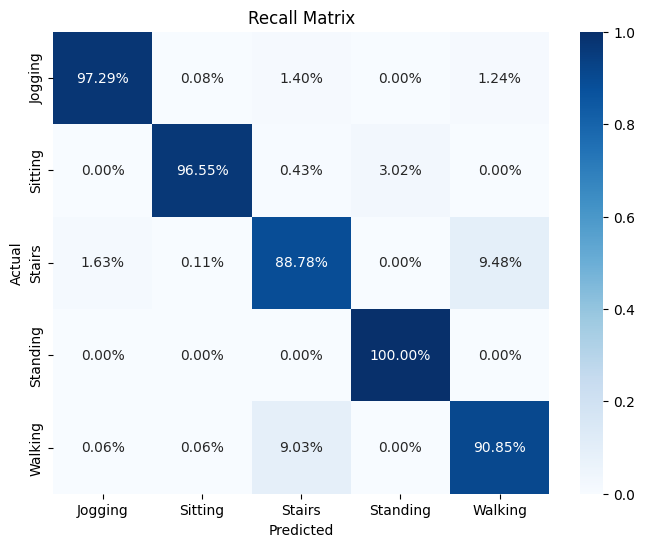

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt




# create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Define your class labels
class_labels = ['Jogging', 'Sitting', 'Stairs', 'Standing', 'Walking']

# calculate recall for each class
recall_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

# plot recall matrix
plt.figure(figsize=(8, 6))
sns.heatmap(recall_matrix, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Recall Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
pip install skl2onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.7/294.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.14.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.


In [ ]:
pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.2 MB/s eta 0:00:00


In [ ]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Create an initial type for the model
initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]

# Convert the scikit-learn model to ONNX format
onnx_model = convert_sklearn(model, initial_types=initial_type)

# Save the ONNX model to a file
with open("genesis.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())


In [ ]:
!python -m onnxruntime.tools.convert_onnx_models_to_ort genesis.onnx

Converting models with optimization style 'Fixed' and level 'all'
Converting optimized ONNX model /content/genesis.onnx to ORT format model /content/genesis.ort
Converted 1/1 models successfully.
Generating config file from ORT format models with optimization style 'Fixed' and level 'all'
2023-11-20 00:14:32,041 ort_format_model.utils [INFO] - Created config in /content/genesis.required_operators.config
Converting models with optimization style 'Runtime' and level 'all'
Converting optimized ONNX model /content/genesis.onnx to ORT format model /content/genesis.with_runtime_opt.ort
Converted 1/1 models successfully.
Converting models again without runtime optimizations to generate a complete config file. These converted models are temporary and will be deleted.
Converting optimized ONNX model /content/genesis.onnx to ORT format model /content/tmpem74683r.without_runtime_opt/genesis.ort
Converted 1/1 models successfully.
Generating config file from ORT format models with optimization styl

In [ ]:
import onnxruntime as ort

# Load the ONNX Runtime model
ort_session = ort.InferenceSession("genesis.ort")


In [ ]:
import numpy as np
import onnxruntime as ort

# Load the ONNX Runtime model
ort_session = ort.InferenceSession("genesis.ort")

# Convert the input data to float32
input_data = np.array(X_test, dtype=np.float32)

# Run inference
output = ort_session.run(None, {'float_input': input_data})

# Extract the predictions
predictions = output[0]
print(predictions)

['Jogging' 'Stairs' 'Jogging' ... 'Walking' 'Jogging' 'Stairs']


In [ ]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

     Jogging       0.99      0.97      0.98      1290
     Sitting       0.99      0.97      0.98       232
      Stairs       0.83      0.89      0.86       918
    Standing       0.97      1.00      0.98       201
     Walking       0.94      0.91      0.92      1662

    accuracy                           0.93      4303
   macro avg       0.94      0.95      0.94      4303
weighted avg       0.93      0.93      0.93      4303



In [ ]:
from imblearn.metrics import classification_report_imbalanced

report = classification_report_imbalanced(y_test, predictions)
print(report)


                   pre       rec       spe        f1       geo       iba       sup

    Jogging       0.99      0.97      0.99      0.98      0.98      0.97      1290
    Sitting       0.99      0.97      1.00      0.98      0.98      0.96       232
     Stairs       0.83      0.89      0.95      0.86      0.92      0.84       918
   Standing       0.97      1.00      1.00      0.98      1.00      1.00       201
    Walking       0.94      0.91      0.96      0.92      0.93      0.87      1662

avg / total       0.93      0.93      0.97      0.93      0.95      0.90      4303

